# Credit Scorecard development case study

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Data Loading and Overview

In [2]:
data = pd.read_csv('data/loan_data_2007_2014.csv')

In [3]:
# data.head()
data.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
433042,11745207,13737342,8500,8500,8500.0,36 months,18.25,308.37,D,D3,Driver/ dispatcher,10+ years,OWN,36000.0,Not Verified,Mar-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 03/03/14 > Pay off outstan...,credit_card,Credit card refinancing,894xx,NV,12.32,2.0,Jan-85,1.0,18.0,NaN,16.0,0.0,8513,31.9,19.0,w,3861.95,3861.95,6784.14000,6784.14,4638.05,2146.09,0.0,0.00,0.00,Jan-16,308.37,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,8534.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26700.0,NaN,NaN,NaN
315544,26087518,28540484,7500,7500,7400.0,36 months,6.49,229.84,A,A2,Claims Specialist,9 years,MORTGAGE,110000.0,Not Verified,Aug-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,021xx,MA,15.42,1.0,Jul-02,0.0,17.0,NaN,11.0,0.0,8809,68.1,27.0,f,4345.56,4287.62,3677.44000,3628.41,3154.44,523.00,0.0,0.00,0.00,Dec-15,229.84,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,335641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14400.0,NaN,NaN,NaN
186607,1854997,2157193,2400,2400,2400.0,36 months,18.49,87.36,D,D2,Intellectual Ventures Management LLC,3 years,RENT,110000.0,Not Verified,Nov-12,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,980xx,WA,10.15,0.0,Jan-95,0.0,68.0,NaN,13.0,0.0,22574,90.3,23.0,f,0.00,0.00,3140.21000,3140.21,2400.00,740.21,0.0,0.00,0.00,Aug-15,344.69,NaN,Jan-16,0.0,68.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,33516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000.0,NaN,NaN,NaN
281117,30575897,33129095,8000,8000,8000.0,36 months,10.99,261.88,B,B3,Criminal investigator,10+ years,MORTGAGE,55000.0,Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,378xx,TN,21.86,0.0,Jan-83,2.0,44.0,NaN,12.0,0.0,7407,30.2,60.0,w,5196.04,5196.04,3661.44000,3661.44,2803.96,857.48,0.0,0.00,0.00,Jan-16,261.88,Feb-16,Jan-16,0.0,46.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,1374.0,24955.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24500.0,NaN,NaN,NaN
143580,4535351,5777555,19800,19800,19800.0,60 months,16.29,484.56,C,C4,State Farm Insurance,10+ years,MORTGAGE,80000.0,Verified,May-13,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt Consolidation,217xx,MD,13.01,2.0,Oct-89,1.0,14.0,NaN,9.0,0.0,34381,86.6,20.0,w,11224.48,11224.48,15505.20000,15505.20,8575.52,6929.68,0.0,0.00,0.00,Jan-16,484.56,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,325702.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39700.0,NaN,NaN,NaN
95274,7085232,8747364,9000,9000,9000.0,36 months,18.85,329.23,D,D3,TempDev,< 1 year,MORTGAGE,97000.0,Source Verified,Sep-13,Current,n,https://www.lendingclub.com/browse/loanDetail....,"Borrower added on 08/30/13 > New roof, repai...",home_improvement,Home Improvement,286xx,NC,11.02,0.0,Nov-00,3.0,NaN,NaN,9.0,0.0,23698,84.0,29.0,f,2457.81,2457.81,9216.49000,9216.49,6542.19,2674.30,0.0,0.00,0.00,Jan-16,329.23,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [5]:
# Get a list of columns that have more than 80% of the values missing
null_values = data.isnull().mean()
null_values[null_values > 0.8]

mths_since_last_record       0.865666
annual_inc_joint             1.000000
dti_joint                    1.000000
verification_status_joint    1.000000
open_acc_6m                  1.000000
open_il_6m                   1.000000
open_il_12m                  1.000000
open_il_24m                  1.000000
mths_since_rcnt_il           1.000000
total_bal_il                 1.000000
il_util                      1.000000
open_rv_12m                  1.000000
open_rv_24m                  1.000000
max_bal_bc                   1.000000
all_util                     1.000000
inq_fi                       1.000000
total_cu_tl                  1.000000
inq_last_12m                 1.000000
dtype: float64

# Remove Empty Columns

In [6]:
# Drop columns that have more than 80% of the values missing
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [7]:
# drop redundant and forward-looking columns
# redundant like id, member_id, title, etc.
# forward-looking like recoveries, collection_recovery_fee, etc.
# drop sub_grade as same information is captured in grade column
# drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model

data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

## Identify the target / dependent variable

In [9]:
# Find the dependent variable - loan_status in this case
data.loan_status.value_counts() 

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [10]:
data.loan_status.value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

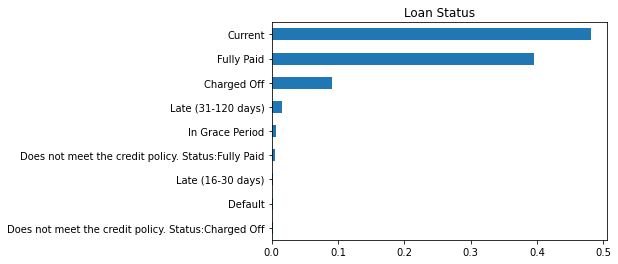

In [11]:
# Plot it as a bar chart
data.loan_status.value_counts(normalize=True).sort_values().plot(kind='barh')
plt.title('Loan Status')
plt.show()

In [12]:
# Create a new column based on loan_status thatt will be our target variable
# 1 - Good Loan (Fully Paid, Current, In Grace Period)
# 0 - Bad Loan (Charged Off, Default, Late (31-120 days), Does not meet the credit policy. Status:Charged Off)
data['good_bad'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)


# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [13]:
data['good_bad'].value_counts(normalize=True)

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

## Split the data into train and test

In [14]:
# Split the data into train and test (80-20 split)
# Use random_state = 42 to ensure that the results are reproducible
# Use stratify to ensure that the proportion of good and bad loans is the same in both train and test sets
X = data.drop(columns = 'good_bad')
y = data['good_bad']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_test = X_train.copy(), X_test.copy()

In [15]:
# Check the shape of the train and test sets
X_train.shape, X_test.shape

((373028, 42), (93257, 42))

# Data Cleaning / Preprocessing

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  pymnt_plan                   466285 non-null  object 
 13 

In [17]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,n,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,n,other,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,n,other,OR,17.94,0.0,Jan-96,0.0,38.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1


In [18]:
# emp_length

def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# Apply to X_train
emp_length_converter(X_train, 'emp_length')

# X_train['emp_length'].value_counts()
X_train['emp_length'].unique()

array([ 7., 10.,  3.,  4.,  2.,  0.,  1.,  6.,  5.,  8.,  9.])

In [19]:
# Convert date columns to datetime format
# And create a new column as a difference between today and the respective date column

def date_converter(df, column):
    # store current month
    today_date = pd.to_datetime('2023-05-14')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_converter(X_train, 'earliest_cr_line')
date_converter(X_train, 'issue_d')
date_converter(X_train, 'last_pymnt_d')
date_converter(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    373003.000000
mean        307.293609
std          86.372742
min         138.000000
25%         248.000000
50%         290.000000
75%         350.000000
max         652.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    373028.000000
mean        116.252485
std          14.339074
min         101.000000
25%         106.000000
50%         112.000000
75%         122.000000
max         191.000000
Name: mths_since_issue_d, dtype: float64
count    372717.000000
mean         96.289989
std          12.803859
min          88.000000
25%          88.000000
50%          89.000000
75%         100.000000
max         185.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    372998.000000
mean         92.041810
std           9.630887
min          88.000000
25%          88.000000
50%          88.000000
75%          90.000000
max         192.000000
Name: mths_since_last_credit_pull_d, dtype: float64


In [20]:
# term column = 36 months, 60 months
# X_train['term'].value_counts()
# remove ' months' from the values and convert to numeric
X_train['term'] = X_train['term'].str.replace(' months', '').astype(int)

In [21]:
X_train.sample(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
372226,6000,6000,6000.0,36,13.35,203.18,C,4.0,RENT,36000.0,Verified,n,debt_consolidation,UT,33.23,0.0,2.0,NaN,9.0,1.0,4483,61.4,11.0,w,3131.18,3131.18,3871.97,3871.97,1003.15,203.18,0.0,NaN,1,INDIVIDUAL,0.0,0.0,66050.0,7300.0,335.0,107.0,88.0,88.0
121162,18000,18000,18000.0,60,13.68,415.85,C,10.0,MORTGAGE,118000.0,Verified,n,debt_consolidation,IL,14.42,2.0,0.0,8.0,14.0,0.0,6855,55.7,35.0,f,10522.66,10522.66,12462.13,12462.13,4984.79,415.85,0.0,66.0,1,INDIVIDUAL,0.0,0.0,215229.0,12300.0,356.0,118.0,88.0,88.0
354982,7000,7000,7000.0,36,9.17,223.16,B,0.0,RENT,23700.0,Verified,n,credit_card,NC,16.56,0.0,0.0,55.0,14.0,0.0,7812,51.1,24.0,w,3739.28,3739.28,4016.88,4016.88,756.16,223.16,0.0,73.0,1,INDIVIDUAL,0.0,128.0,7812.0,15300.0,426.0,106.0,88.0,88.0
123810,7000,7000,7000.0,36,14.09,239.55,B,1.0,RENT,34000.0,Not Verified,n,credit_card,FL,17.01,0.0,0.0,NaN,5.0,0.0,6633,75.4,8.0,w,0.00,0.00,3360.72,3360.72,798.82,239.55,0.0,NaN,1,INDIVIDUAL,0.0,0.0,28423.0,8800.0,182.0,119.0,108.0,103.0
373109,24300,24300,24300.0,36,6.49,744.67,A,0.0,MORTGAGE,78000.0,Source Verified,n,debt_consolidation,GA,13.85,0.0,1.0,56.0,17.0,0.0,6214,11.1,35.0,w,0.00,0.00,25734.81,25734.81,1434.81,13820.09,0.0,NaN,1,INDIVIDUAL,0.0,0.0,257791.0,56100.0,347.0,107.0,94.0,93.0


In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   grade                          373028 non-null  object 
 7   emp_length                     373028 non-null  float64
 8   home_ownership                 373028 non-null  object 
 9   annual_inc                     373024 non-null  float64
 10  verification_status            373028 non-null  object 
 11  pymnt_plan                     373028 non-null  object 
 12  purpose                   

# Feature Selection

In [23]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

## Chi-squared statistic for categorical variables

In [24]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))

    chi_sq_results.setdefault('Feature', []).append(col)
    chi_sq_results.setdefault('p-value', []).append(round(pi, 10))


# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results.sort_values(by = 'p-value', ascending = True, ignore_index=True, inplace = True)

chi_sq_results


,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,pymnt_plan,0.000923
7,application_type,1.000000


We will use the chi-squared statistic to identify the categorical variables that are most predictive of the target variable. We will select the top 4 variables.
Those columns are: 'application_type', 'pymnt_plan', 'addr_state', 'home_ownership'

## ANOVA F-Statistic for numerical variables

In [25]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   emp_length                     373028 non-null  float64
 7   annual_inc                     373024 non-null  float64
 8   dti                            373028 non-null  float64
 9   delinq_2yrs                    373003 non-null  float64
 10  inq_last_6mths                 373003 non-null  float64
 11  mths_since_last_delinq         172651 non-null  float64
 12  open_acc                  

In [26]:
# Since f_class_if does not accept missing values, wee will do a avery crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,23513.805570,0.000000e+00
1,total_pymnt_inv,14784.534040,0.000000e+00
2,total_pymnt,14686.729567,0.000000e+00
3,int_rate,11462.788313,0.000000e+00
4,last_pymnt_amnt,10826.949727,0.000000e+00
5,out_prncp,9635.116160,0.000000e+00
6,out_prncp_inv,9633.442129,0.000000e+00
7,mths_since_last_credit_pull_d,7020.218888,0.000000e+00
8,mths_since_issue_d,2816.028871,0.000000e+00
9,inq_last_6mths,2003.820465,0.000000e+00


In [27]:
X_train_num.policy_code.value_counts()

1    373028
Name: policy_code, dtype: int64

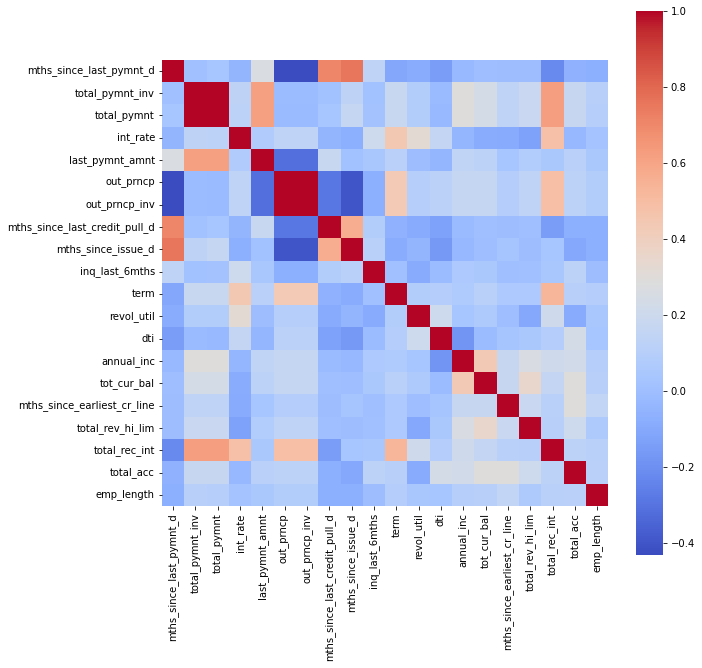

In [28]:
# Keep the top 20 numerical features
top_num_features = ANOVA_F_table.iloc[:20, 0].tolist()
# Calculate the pair-wise correlations between the variables
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');


# # Do it again for all the features
# corrmat = X_train_num.corr()
# plt.figure(figsize = (10, 10))
# sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');



The ANOVA F-Statistic is used to identify the numerical variables that are most predictive of the target variable. We will select the top 4 variables. Those columns are: 'total_rec_late_fee', 'total_rec_int', 'total_rec_prncp', 'recoveries'

In [29]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi_sq_results.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

# Create Dummy Variables

In [30]:
# Convert the categorical variables to dummy variables
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   term                           373028 non-null  int64  
 1   int_rate                       373028 non-null  float64
 2   grade                          373028 non-null  object 
 3   emp_length                     373028 non-null  float64
 4   home_ownership                 373028 non-null  object 
 5   annual_inc                     373024 non-null  float64
 6   verification_status            373028 non-null  object 
 7   purpose                        373028 non-null  object 
 8   dti                            373028 non-null  float64
 9   inq_last_6mths                 373003 non-null  float64
 10  revol_util                     372764 non-null  float64
 11  total_acc                      373003 non-null  float64
 12  out_prncp                 

In [31]:
def create_dummy(df, column_list):
    '''
    This function will create dummy variables for the categorical variables

    df: the dataframe
    column_list: list of categorical columns
    '''
    df_dummies = []
    for col in column_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to X_train
X_train = create_dummy(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])



In [32]:
X_train.sample(5)

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
254505,36,17.86,D,4.0,RENT,34000.0,Not Verified,debt_consolidation,17.12,1.0,33.6,11.0,8031.66,5371.53,1903.19,414.95,13077.0,13200.0,177.0,102.0,88.0,88.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
213408,36,13.99,C,0.0,OWN,47424.0,Not Verified,debt_consolidation,10.73,1.0,44.8,20.0,0.00,14833.81,1158.81,10457.71,NaN,NaN,224.0,131.0,123.0,108.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
346576,36,19.52,E,0.0,OWN,40000.0,Source Verified,debt_consolidation,13.53,5.0,60.6,33.0,0.00,1014.96,153.74,176.30,24150.0,5900.0,249.0,106.0,104.0,99.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
139229,36,10.16,B,2.0,MORTGAGE,72000.0,Source Verified,home_improvement,11.98,1.0,18.2,61.0,1975.82,16145.60,2521.42,504.55,290791.0,10700.0,340.0,120.0,88.0,88.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
375145,60,13.98,C,6.0,MORTGAGE,55000.0,Not Verified,credit_card,28.30,0.0,66.2,33.0,7547.23,4419.02,1966.25,232.58,228665.0,22500.0,238.0,107.0,88.0,88.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Update the Test set

In [33]:
# Update the Test set
emp_length_converter(X_test, 'emp_length')
date_converter(X_test, 'earliest_cr_line')
date_converter(X_test, 'issue_d')
date_converter(X_test, 'last_pymnt_d')
date_converter(X_test, 'last_credit_pull_d')
X_test['term'] = X_test['term'].str.replace(' months', '').astype(int)
col_to_drop(X_test, drop_columns_list)
X_test = create_dummy(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# Weight of Evidence (WoE) - Binning / Feature Engineering

- We will analyze both categorical and numerical features on their categorical/binned WoEs and IVs (Information Value) and then combine some of these binned categories together through a custom Python Class with fit_transform method.

In [34]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

In [35]:
# # Export the preprocessed training and test sets
# X_train_prepr.to_csv('prep_data/X_train_prepr.csv', index = False)
# y_train_prepr.to_csv('prep_data/y_train_prepr.csv', index = False)
# X_test_prepr.to_csv('prep_data/X_test_prepr.csv', index = False)
# y_test_prepr.to_csv('prep_data/y_test_prepr.csv', index = False)

## Analyze WoEs and IVs of discrete features

In [36]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


sns.set()
# Function for plotting WoE across categoris that takes 2 arguments: a dataframe and a number
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = 'dotted', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    


**grade**

In [37]:
df = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


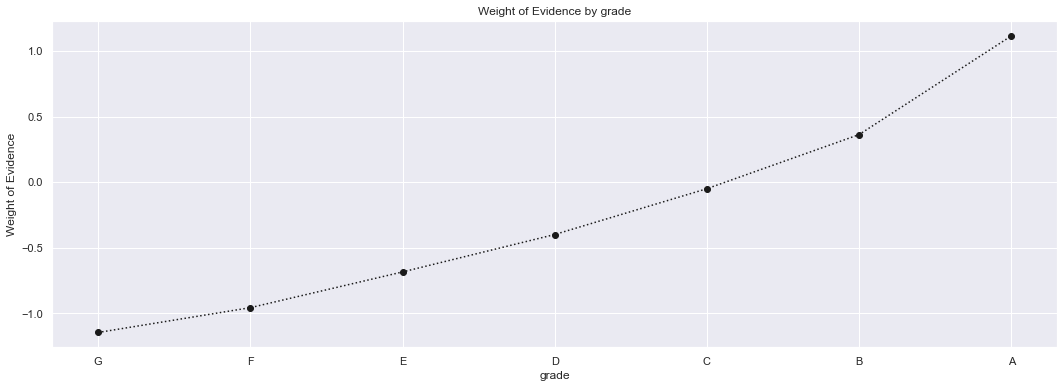

In [38]:
plot_by_woe(df)

**home_ownership**

In [39]:
df = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


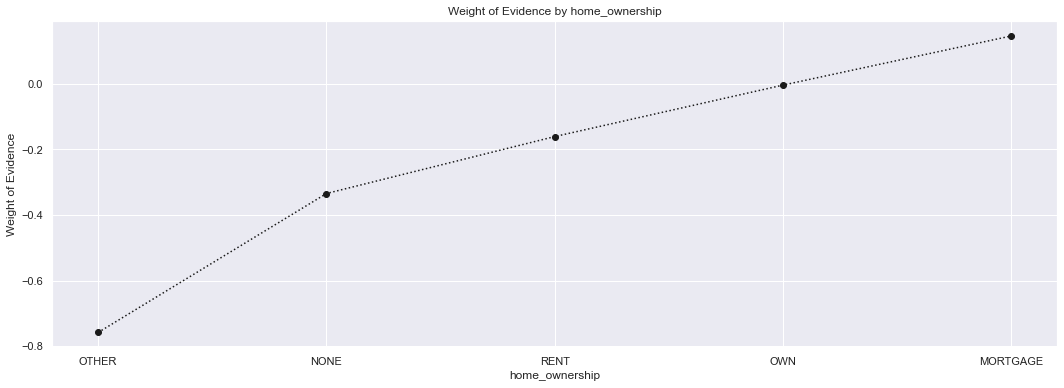

In [40]:
plot_by_woe(df)

**verification_status**

In [41]:
df = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134571,0.872045,0.360753,117352.0,17219.0,0.353200,0.422303,-0.178691,NaN,NaN,0.022522
1,Source Verified,119969,0.895723,0.321609,107459.0,12510.0,0.323424,0.306813,0.052726,0.023678,0.231417,0.022522
2,Not Verified,118488,0.906784,0.317638,107443.0,11045.0,0.323376,0.270883,0.177128,0.011061,0.124402,0.022522


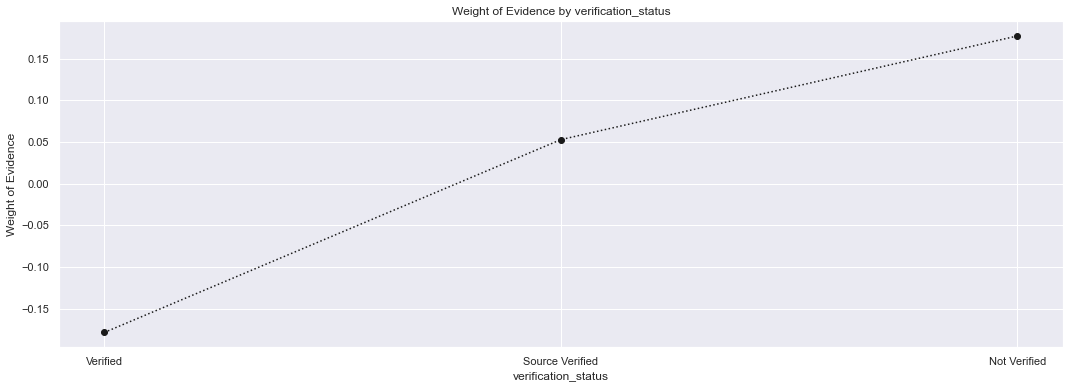

In [42]:
plot_by_woe(df)

**purpose**

In [43]:
df = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)

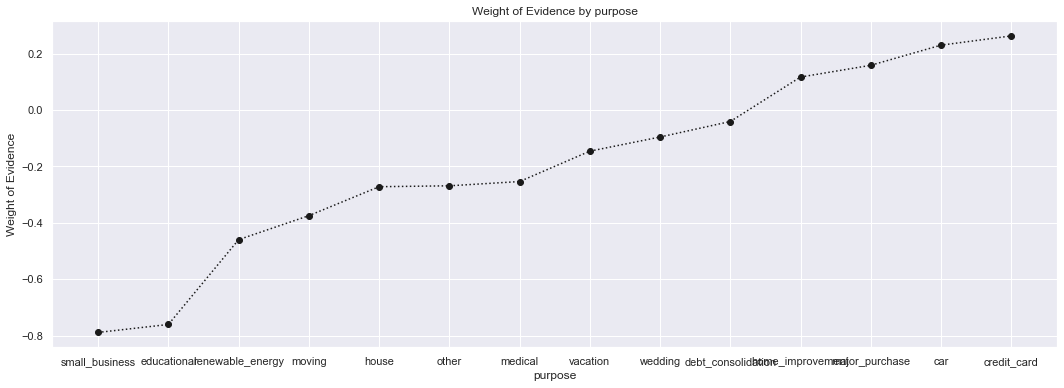

In [44]:
plot_by_woe(df)

# Model

In [45]:
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']


In [46]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373028, 51)
(373028,)
(93257, 51)
(93257,)


In [47]:
from src.transformer import WoE_Binning

# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8625
Gini: 0.7250


In [48]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0           NaN          NaN               NaN  
1                  0.0           NaN          NaN               NaN  
2        

In [49]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,3.301807
1,grade:A,0.830405
2,grade:B,0.642763
3,grade:C,0.496073
4,grade:D,0.408912
...,...,...
80,mths_since_issue_d:100-122,0.082466
81,mths_since_last_credit_pull_d:missing,0.181001
82,mths_since_last_credit_pull_d:<56,0.000000
83,mths_since_last_credit_pull_d:56-61,0.000000


In [50]:
# show all summary_trable rows
# pd.set_option('display.max_rows', None)
# summary_table

# Predictions

In [51]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [52]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(93257, 2)

In [53]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
395346,1,0.314027
376583,1,0.899418
297790,1,0.599359
47347,1,0.818937
446772,0,0.117225


## Confusion Matrix and AUROC on Test Set

In [54]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.0886475 , 0.02066333],
       [0.19074171, 0.69994746]])

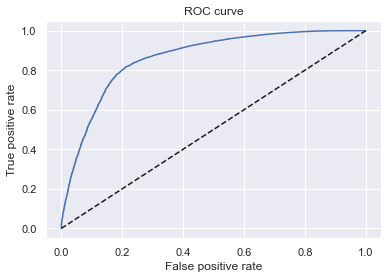

In [55]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [56]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.8623528888987211

In [57]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.7247057777974422

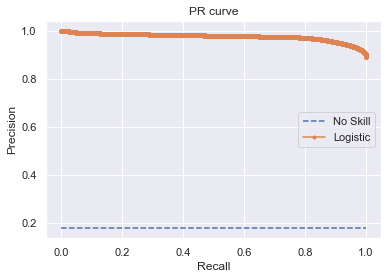

In [58]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [59]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9756461229917849

# Applying the Model - Scorecard Creation

In [60]:
summary_table

,Feature name,Coefficients
0,Intercept,3.301807
1,grade:A,0.830405
2,grade:B,0.642763
3,grade:C,0.496073
4,grade:D,0.408912
...,...,...
80,mths_since_issue_d:100-122,0.082466
81,mths_since_last_credit_pull_d:missing,0.181001
82,mths_since_last_credit_pull_d:<56,0.000000
83,mths_since_last_credit_pull_d:56-61,0.000000


In [61]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,mths_since_last_credit_pull_d:>75,0
1,mths_since_issue_d:>122,0
2,mths_since_earliest_cr_line:>434,0
3,"total_rev_hi_lim:>79,780",0
4,"total_rec_int:>7,260",0
5,"total_pymnt:>25,000",0
6,"out_prncp:>15,437",0
7,revol_util:>1.0,0
8,inq_last_6mths:>4,0
9,dti:>35.191,0


In [62]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,3.301807
1,1,grade:A,0.830405
2,2,grade:B,0.642763
3,3,grade:C,0.496073
4,4,grade:D,0.408912
...,...,...,...
97,12,term:60,0.000000
98,13,purpose:major_purch__car__home_impr,0.000000
99,14,verification_status:Not Verified,0.000000
100,15,home_ownership:MORTGAGE,0.000000


In [63]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,3.301807,Intercept
1,1,grade:A,0.830405,grade
2,2,grade:B,0.642763,grade
3,3,grade:C,0.496073,grade
4,4,grade:D,0.408912,grade
...,...,...,...,...
97,12,term:60,0.000000,term
98,13,purpose:major_purch__car__home_impr,0.000000,purpose
99,14,verification_status:Not Verified,0.000000,verification_status
100,15,home_ownership:MORTGAGE,0.000000,home_ownership


In [64]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [65]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,3.301807,Intercept,613.163298,613.0
1,1,grade:A,0.830405,grade,22.058786,22.0
2,2,grade:B,0.642763,grade,17.074276,17.0
3,3,grade:C,0.496073,grade,13.177627,13.0
4,4,grade:D,0.408912,grade,10.862303,11.0
...,...,...,...,...,...,...
97,12,term:60,0.000000,term,0.000000,0.0
98,13,purpose:major_purch__car__home_impr,0.000000,purpose,0.000000,0.0
99,14,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0
100,15,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0


In [66]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
849.0


In [67]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,3.301807,Intercept,613.163298,613.0,-0.163298
1,1,grade:A,0.830405,grade,22.058786,22.0,-0.058786
2,2,grade:B,0.642763,grade,17.074276,17.0,-0.074276
3,3,grade:C,0.496073,grade,13.177627,13.0,-0.177627
4,4,grade:D,0.408912,grade,10.862303,11.0,0.137697
5,5,grade:E,0.297109,grade,7.892361,8.0,0.107639
6,6,grade:F,0.164700,grade,4.375063,4.0,-0.375063
7,7,home_ownership:OWN,-0.059475,home_ownership,-1.579892,-2.0,-0.420108
8,8,home_ownership:OTHER_NONE_RENT,-0.106230,home_ownership,-2.821882,-3.0,-0.178118
9,9,verification_status:Source Verified,-0.293704,verification_status,-7.801912,-8.0,-0.198088


In [68]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,3.301807,Intercept,613.163298,613.0,-0.163298,598.0
1,1,grade:A,0.830405,grade,22.058786,22.0,-0.058786,22.0
2,2,grade:B,0.642763,grade,17.074276,17.0,-0.074276,17.0
3,3,grade:C,0.496073,grade,13.177627,13.0,-0.177627,13.0
4,4,grade:D,0.408912,grade,10.862303,11.0,0.137697,11.0
5,5,grade:E,0.297109,grade,7.892361,8.0,0.107639,8.0
6,6,grade:F,0.164700,grade,4.375063,4.0,-0.375063,4.0
7,7,home_ownership:OWN,-0.059475,home_ownership,-1.579892,-2.0,-0.420108,-2.0
8,8,home_ownership:OTHER_NONE_RENT,-0.106230,home_ownership,-2.821882,-3.0,-0.178118,-3.0
9,9,verification_status:Source Verified,-0.293704,verification_status,-7.801912,-8.0,-0.198088,-8.0


In [69]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

285.0
834.0


## Calculating credit scores for all observations in the test data set

In [70]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:OTHER_NONE_RENT,verification_status:Source Verified,verification_status:Verified,purpose:debt_consolidation,purpose:credit_card,purpose:educ__ren_en__sm_b__mov,purpose:vacation__house__wedding__med__oth,term:36,int_rate:<7.071,int_rate:7.071-10.374,int_rate:10.374-13.676,int_rate:13.676-15.74,int_rate:15.74-20.281,annual_inc:missing,"annual_inc:<28,555","annual_inc:28,555-37,440","annual_inc:37,440-61,137","annual_inc:61,137-81,872","annual_inc:81,872-102,606","annual_inc:102,606-120,379","annual_inc:120,379-150,000",dti:<=1.6,dti:1.6-5.599,dti:5.599-10.397,dti:10.397-15.196,dti:15.196-19.195,dti:19.195-24.794,dti:24.794-35.191,inq_last_6mths:missing,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-4,revol_util:missing,revol_util:<0.1,revol_util:0.1-0.2,revol_util:0.2-0.3,revol_util:0.3-0.4,revol_util:0.4-0.5,revol_util:0.5-0.6,revol_util:0.6-0.7,revol_util:0.7-0.8,revol_util:0.8-0.9,revol_util:0.9-1.0,"out_prncp:<1,286","out_prncp:1,286-6,432","out_prncp:6,432-9,005","out_prncp:9,005-10,291","out_prncp:10,291-15,437","total_pymnt:<10,000","total_pymnt:10,000-15,000","total_pymnt:15,000-20,000","total_pymnt:20,000-25,000","total_rec_int:<1,089","total_rec_int:1,089-2,541","total_rec_int:2,541-4,719","total_rec_int:4,719-7,260",total_rev_hi_lim:missing,"total_rev_hi_lim:<6,381","total_rev_hi_lim:6,381-19,144","total_rev_hi_lim:19,144-25,525","total_rev_hi_lim:25,525-35,097","total_rev_hi_lim:35,097-54,241","total_rev_hi_lim:54,241-79,780",mths_since_earliest_cr_line:missing,mths_since_earliest_cr_line:<125,mths_since_earliest_cr_line:125-167,mths_since_earliest_cr_line:167-249,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61,mths_since_last_credit_pull_d:61-75
395346,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
376583,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
297790,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
47347,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
446772,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [71]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 85)
(102,)


In [72]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 102)
(102, 1)


In [73]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
395346,489.0
376583,568.0
297790,521.0
47347,549.0
446772,457.0


In [79]:
# Show all y_scores

y_scores.sample(10)


,0
460633,593.0
156726,487.0
93280,560.0
241023,512.0
45839,503.0
57586,554.0
164573,444.0
315785,580.0
48552,541.0
126549,488.0


In [80]:
y_scores.value_counts()

550.0    1003
547.0     987
545.0     971
556.0     970
544.0     957
         ... 
685.0       1
373.0       1
379.0       1
378.0       1
719.0       1
Length: 327, dtype: int64